# Solution: Problem 2 (including time delay)

## First, we install packages that we will need. Skip this step if packages are already installed.

In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install astropy
!{sys.executable} -m pip install pycbc


## Import necessary packages

In [4]:
from astropy.cosmology import Planck15
from astropy import constants
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pycbc.psd
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from tqdm import tqdm

## Define the star formation rate as a function of both z and lookback time

In [5]:
z_arr = np.logspace(-6, np.log10(1000), 100000)
lookback_time_to_z = interp1d(Planck15.lookback_time(z_arr).to(u.Myr).value, z_arr)

def Rstar_z(z):
    """
    The star formation rate as a function of redshift
    """
    
    a, b, zm = 2.8, 2.46, 1.72
    nu = 24 / u.yr / u.Gpc ** 3
    numerator = nu * a * np.exp(b * (z - zm))
    denominator = a - b + b * np.exp(a * (z - zm))
    return numerator / denominator

def Rstar_tL(lookback_time):
    """
    The star formation rate as a function of lookback time
    """
    useful_indices = np.intersect1d(
                        np.where(lookback_time < 1.377e4),
                        np.where(lookback_time > 1),
    )
    result = np.zeros_like(lookback_time)
    result[useful_indices] = Rstar_z(lookback_time_to_z(lookback_time[useful_indices]))
    return result / u.yr / u.Gpc ** 3

In [26]:
def dEdf(freq, factor):
    numerator =  np.pi ** (2/3) * constants.G ** (2/3) * factor * freq ** (-1/3)
    denominator = 3  * constants.c ** 2
    return numerator / denominator


def Rv_z(z, time_delay_distribution, time_delay_args=dict()):
    lookback_time = Planck15.lookback_time(z).to(u.Myr).value
    result = np.zeros_like(z) / u.yr / u.Gpc ** 3
    
    time_delay_arr = np.logspace(np.log10(1e-3), np.log10(1e4), 100000)
    for ii in range(len(z)):
        integrand = Rstar_tL(lookback_time[ii] + time_delay_arr) * time_delay_distribution(time_delay_arr,
                                                                                          **time_delay_args)
        result[ii] = np.trapz(integrand, time_delay_arr)
        
    return result
    
def omega_GW_with_time_delay(f_arr, chirp_mass_distribution,
                                time_delay_distribution,
                                chirp_mass_args=dict(),
                                time_delay_args=dict()
                               ):
    f_arr = np.asarray(f_arr) * u.Hz
    result = np.zeros_like(f_arr.value)
    z = np.linspace(0.01, 10, 100)
    delta_z = z[1] - z[0]
    
    if chirp_mass_distribution == "delta_function":
        print("Using Delta Function distribution")
        factor = chirp_mass_args["val"] ** (5/3) * u.M_sun ** (5/3)
    
    else:
        delta_chirp_mass = 0.1
        chirp_mass_arr = np.arange(0, 200, delta_chirp_mass)
        factor_integrand = chirp_mass_arr ** (5/3) * chirp_mass_distribution(chirp_mass_arr, **extra_args)
        factor = np.sum(factor_integrand) * delta_chirp_mass  * u.M_sun ** (5/3)
        print(factor)
    
    rate = Rv_z(z, time_delay_distribution, time_delay_args)
#     plt.plot(z, rate)
#     plt.grid()
#     plt.show()

    for index, freq in tqdm(enumerate(f_arr)):
        prefactor = freq / (Planck15.critical_density0 * Planck15.H0) 
        integrand = rate / (1 + z) * Planck15.inv_efunc(z) * dEdf(freq * (1 + z), factor) 
        result[index] = prefactor * np.sum(integrand) * delta_z
    return result



In [27]:
def gaussian(x, mu, sigma):
    return 1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp((x - mu) ** 2  / 2 / sigma **2)

def flat(x, minimum, maximum):
    y = np.zeros_like(x)
    useful_indices = np.intersect1d(
        np.where(x > minimum), np.where(x < maximum)
    )
    y[useful_indices] = 1 / (maximum - minimum)
    return y

def inverse_x(x, minimum, maximum):
    y = np.zeros_like(x)
    useful_indices = np.intersect1d(
        np.where(x > minimum), np.where(x < maximum)
    )
    y[useful_indices] = 1 / x[useful_indices]
    y /= np.log(maximum/minimum)
    return y
    

Using Delta Function distribution


100it [00:00, 925.51it/s]


Using Delta Function distribution


100it [00:00, 549.83it/s]


(5, 1000)

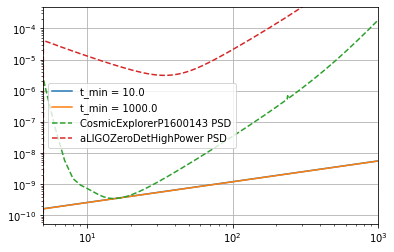

In [33]:
f_arr = np.arange(5, 1000, 10)
for tmin in [1e1, 1e3]:
    omega = omega_GW_with_time_delay(f_arr,
                                     chirp_mass_distribution="delta_function",
                                     time_delay_distribution=inverse_x,
                                     chirp_mass_args=dict(val=30),
                                    time_delay_args=dict(minimum=tmin, maximum=1e4))
    plt.loglog(f_arr, omega, label=f"t_min = {tmin}")

for name in ["CosmicExplorerP1600143", "aLIGOZeroDetHighPower"]:
    psd = pycbc.psd.analytical.from_string(name, 2000, 1, 5)
    psd_data = psd.data / u.Hz
    psd_frequencies = psd.sample_frequencies * u.Hz
    psd = (psd_data * (psd_frequencies) ** 3 / constants.G / Planck15.critical_density0).si * np.pi/4
    plt.plot(psd_frequencies, psd, label=name + " PSD", ls="--")
plt.legend(loc="best")
plt.ylim(ymax=5e-4)
plt.grid()
plt.xlim(5, 1000)